# Distribution of the Sobol' indices on Ishigami function

In this document, we consider the Ishigami function and check the distribution computed by OpenTURNS.



In [1]:
import openturns as ot
import otbenchmark as otb
import openturns.viewer as otv
import numpy as np

When we estimate Sobol' indices, we may encounter the following warning messages:
```
WRN - The estimated first order Sobol index (2) is greater than its total order index . You may increase the sampling size.
WRN - The estimated total order Sobol index (2) is lesser than first order index . You may increase the sampling size.
```
Lots of these messages are printed in the current Notebook. This is why we disable them with:

In [2]:
ot.Log.Show(ot.Log.NONE)

In [3]:
problem = otb.IshigamiSensitivity()
problem

In [4]:
print(problem)

name = Ishigami
distribution = ComposedDistribution(Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), IndependentCopula(dimension = 3))
function = ParametricEvaluation([X1,X2,X3,a,b]->[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)], parameters positions=[3,4], parameters=[a : 7, b : 0.1], input positions=[0,1,2])
firstOrderIndices = [0.313905,0.442411,0]
totalOrderIndices = [0.557589,0.442411,0.243684]


Bootstrap
Estimator: Saltelli
Estimator: Martinez
Estimator: Jansen
Estimator: MauntzKucherenko
Asymptotic
Estimator: Saltelli
Estimator: Martinez
Estimator: Jansen
Estimator: MauntzKucherenko


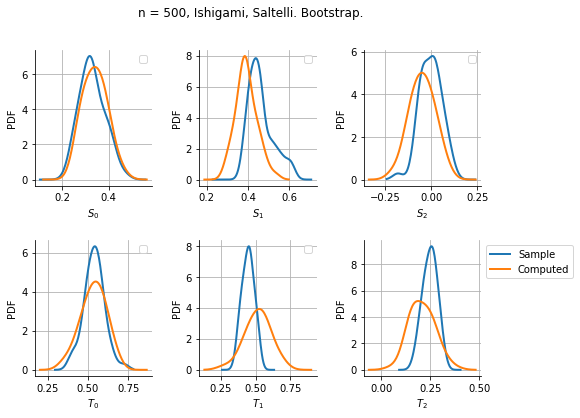

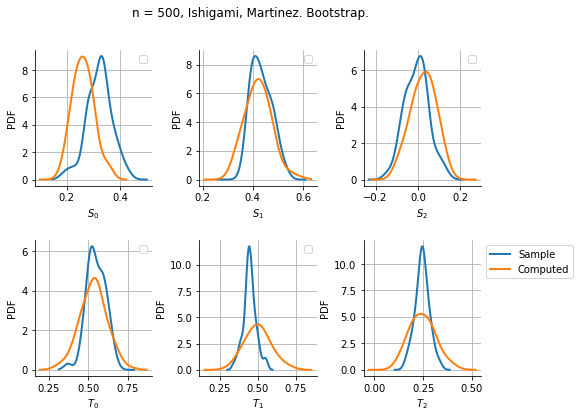

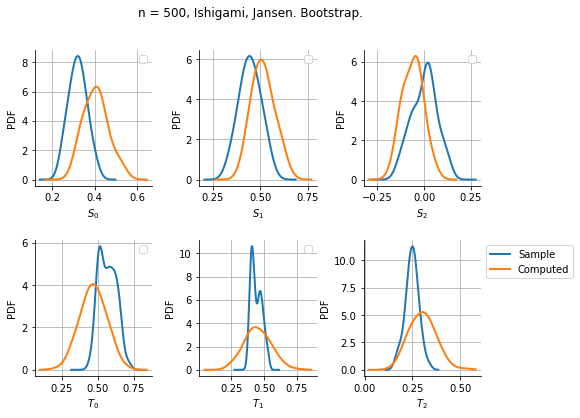

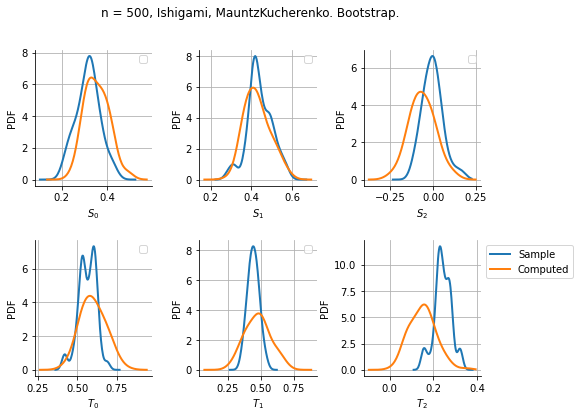

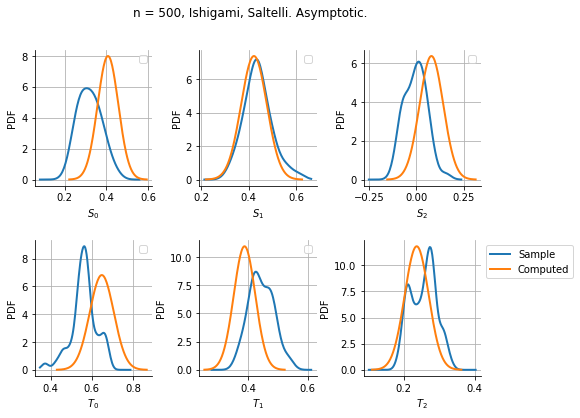

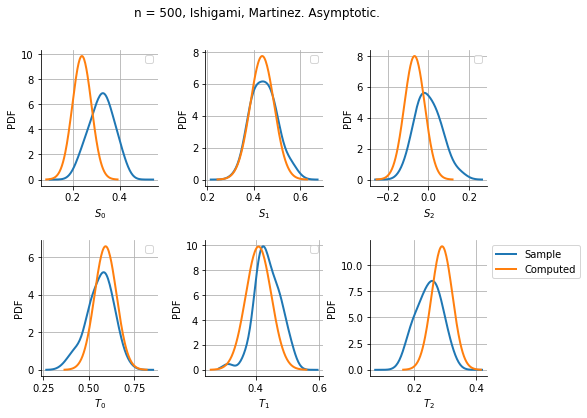

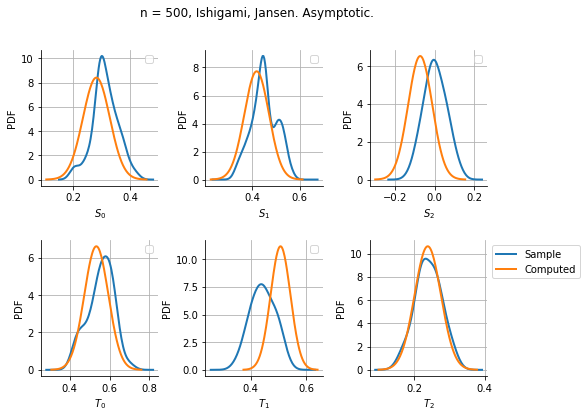

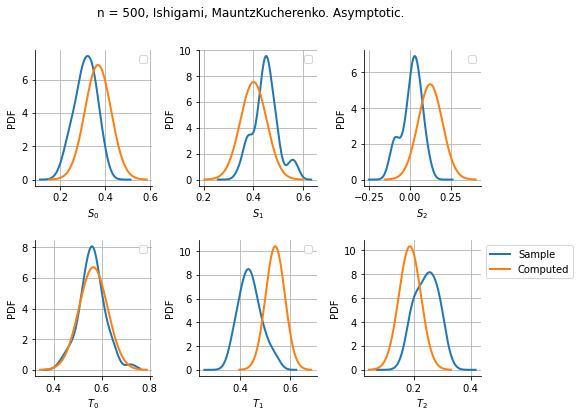

In [9]:
sampleSize = 500
problem = otb.IshigamiSensitivity()
metaSAAlgorithm = otb.SensitivityBenchmarkMetaAlgorithm(problem)
for useAsymptotic in [False, True]:
    if useAsymptotic:
        label = "Asymptotic"
    else:
        label = "Bootstrap"
    print(label)
    ot.ResourceMap.SetAsBool(
        "SobolIndicesAlgorithm-DefaultUseAsymptoticDistribution", useAsymptotic
    )
    for estimator in ["Saltelli", "Martinez", "Jansen", "MauntzKucherenko"]:
        print("Estimator:", estimator)
        benchmark = otb.SensitivityDistribution(
            problem, metaSAAlgorithm, sampleSize=sampleSize, numberOfRepetitions=50,
        )
        grid = benchmark.draw()
        view = otv.View(grid)
        figure = view.getFigure()
        _ = figure.suptitle(
            "n = %d, %s, %s. %s." % (sampleSize, problem.getName(), estimator, label)
        )
        figure.set_figwidth(8.0)
        figure.set_figheight(6.0)
        figure.subplots_adjust(wspace=0.4, hspace=0.4)
        # Customize legends
        ax = figure.get_axes()
        for i in range(len(ax) - 1):
            ax[i].legend("")
        _ = ax[-1].legend(bbox_to_anchor=(1.0, 1.0))